In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here, but you will need to set
# dark_mode = False

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

In [2]:
# create some fake data

npts = 11
xlow = 0.5
xhigh = 5.5

xi = np.linspace(xlow,xhigh,npts)
yrandom = stats.norm.rvs(size=npts,loc=0,scale=.2) # Add some "noise" to the data

# The "equation" that we will fit is the line y=x.  Thus, we expect,
# in all cases, a slope of 1 and a y-intercept of 0.

yi = xi + yrandom

# For later .... generate the yi using an exponential function instead
#yi = 0.5*np.exp(0.48*xi)+ yrandom

# Create an array of uncertainties in y that increase with increasing x
xl = xlow + 0.1
sigmai = np.array([0.05 + 0.15*(xi[i]-xl) for i in range(npts)])

Text(0.5, 1.0, 'Fake Data with Increasing Uncertainties')

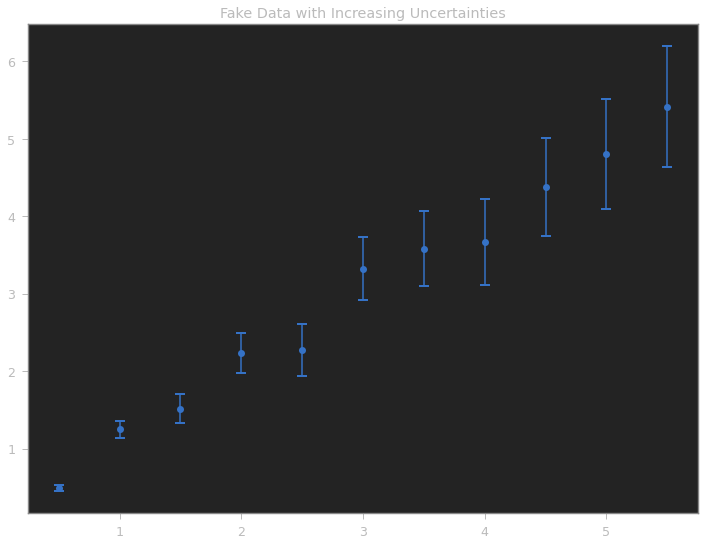

In [3]:
# Let's plot this data, just to see what it looks like

plt.rcParams["figure.figsize"] = (12,9)

figure, axis = plt.subplots(1, 1)
plot1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)

plot1.errorbar(xi, yi, yerr=sigmai, fmt='o', capsize=5, capthick=2)
plot1.set_title("Fake Data with Increasing Uncertainties")

In [4]:
# So, to fit this data using curve_fit, we need two things:
#
# 1. A fitting function
# 2. A list of initial guesses for the fit parameters
#

def linearfitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

init_vals = [0.0 for x in range(2)]

# Now, we are ready to call the curve_fit function
#
# It returns a list of the best fit parameters (popt), and the covariance matrix
# which is a (n x n) square matrix, where n is the number of fit parameters.  The
# diagonal elements of the covariance matrix can be used to calculate uncertainties
# in the parameters!

popt, pcov = curve_fit(linearfitfunction,xi,yi,p0=init_vals,sigma=sigmai)
perr = np.sqrt(np.diag(pcov))

Linear Fit: Coefficients (from curve_fit)
[0.00243772 1.02266227]
Linear Fit: Covariance Matrix (from curve_fit)
[[ 0.00192954 -0.0016527 ]
 [-0.0016527   0.00242511]]

Linear Fit: Final Result: y = (1.02266 +/- 0.04925) x + (0.00244 +/- 0.04393)



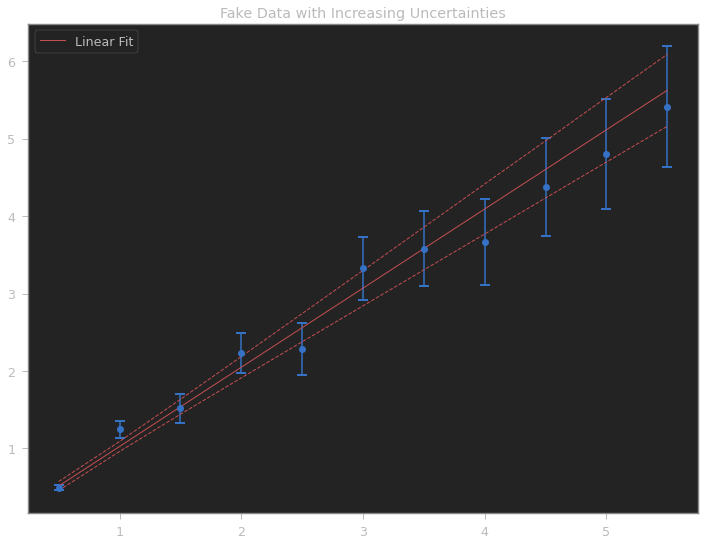

In [5]:
# For plotting purposes, let's do a neat thing to illustrate how the uncertainties in the
# fit parameters affect things.
#
# The idea here is that we will create randomly sample the best fit parameters, using
# the covariance matrix as a constraint, a whole bunch of times (10000 in this case).
# 'ps' will be a 10000 x n 2D matrix, where n is the number of fit parameters.
#
# Then, we create 10000 different fit lines (ysample), using these 10000 different sets
# of fit parameters.
#
# Finally, we choose upper and lower bounds, based on a 95% confidence interval.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([linearfitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,2.5,axis=0)
upper = np.percentile(ysample,97.5,axis=0)
middle = (lower+upper)/2.0

print("Linear Fit: Coefficients (from curve_fit)")
print (popt)
print("Linear Fit: Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Linear Fit: Final Result: y = (%0.5f +/- %0.5f) x + (%0.5f +/- %0.5f)" % (popt[1],perr[1],popt[0],perr[0]))
print()

plot1.plot(xi,middle,'r-',label="Linear Fit",linewidth=1)
plot1.plot(xi,lower,'r--',linewidth=1)
plot1.plot(xi,upper,'r--',linewidth=1)

plot1.legend()
figure

Trig Fit: Coefficients (from curve_fit)
[0.49008008 0.48904288]
Trig Fit: Covariance Matrix (from curve_fit)
[[ 0.00617585 -0.00316744]
 [-0.00316744  0.0028118 ]]

Trig Fit: Final Result: y = (0.49008 +/- 0.07859)exp((0.48904 +/- 0.05303)x)



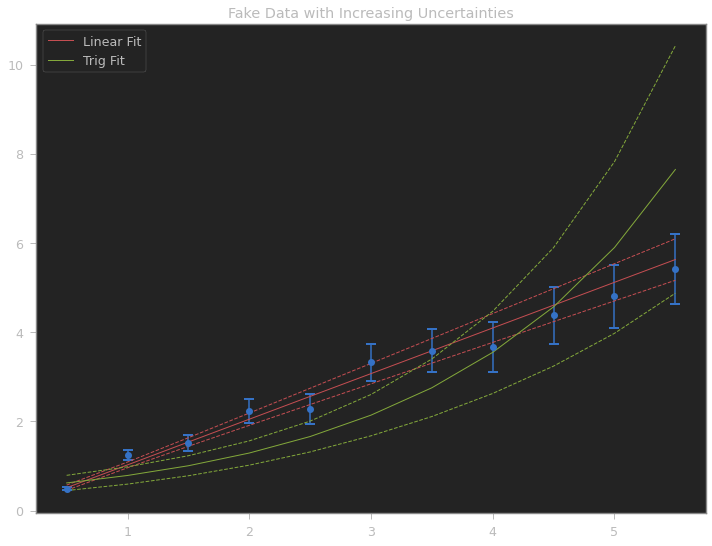

In [6]:
# Now, let's try fitting the data with a different fitting function:  an exponential function
#
# The rest of the code is almost exactly the same as above!

def expfitfunction(x,*paramlist):
    return paramlist[0]*np.exp(paramlist[1]*x)

init_vals2 = [0.5,0.48]

popt2, pcov2 = curve_fit(expfitfunction,xi,yi,p0=init_vals2,sigma=sigmai)
perr2 = np.sqrt(np.diag(pcov2))

ps2 = np.random.multivariate_normal(popt2,pcov2,10000)
ysample2=np.asarray([expfitfunction(xi,*pi2) for pi2 in ps2])

lower2 = np.percentile(ysample2,2.5,axis=0)
upper2 = np.percentile(ysample2,97.5,axis=0)
middle2 = (lower2+upper2)/2.0

print("Trig Fit: Coefficients (from curve_fit)")
print (popt2)
print("Trig Fit: Covariance Matrix (from curve_fit)")
print (pcov2)

print()
print ("Trig Fit: Final Result: y = (%0.5f +/- %0.5f)exp((%0.5f +/- %0.5f)x)" % (popt2[0],perr2[0],popt2[1],perr2[1]))
print()

plot1.plot(xi,middle2,'g-',label="Trig Fit",linewidth=1)
plot1.plot(xi,lower2,'g--',linewidth=1)
plot1.plot(xi,upper2,'g--',linewidth=1)

plot1.legend()
figure

In [7]:
# Which is the better fit?  We should use our eyes as guidance, but we need a mathematical
# measurement, right?
#
# Since we are trying to minimize X^2, let's calculate it in each case.

def calc_chisquare(meas, sigma, fit): 
    diff = pow(meas-fit, 2.)
    test_statistic = (diff / pow(sigma,2.)).sum()
    return test_statistic

TS = calc_chisquare(yi, sigmai, linearfitfunction(xi, *popt))
NDF = len(yi) - len(popt)
print("Linear Fit: chisquare/NDF = {0:.2f} / {1:d}  = {2:.2f}".format(TS, NDF, TS / float(NDF)))

TS2 = calc_chisquare(yi, sigmai, expfitfunction(xi, *popt2))
NDF2 = len(yi) - len(popt2)
print("Exp Fit: chisquare/NDF = {0:.2f} / {1:d}  = {2:.2f}".format(TS2, NDF2, TS2 / float(NDF2)))


Linear Fit: chisquare/NDF = 7.02 / 9  = 0.78
Exp Fit: chisquare/NDF = 72.87 / 9  = 8.10


In [8]:
# Extrapolation and Interpolation
#
# What if, after doing the fit(s), we wanted to know the value of y, from the fit, for a
# given value of x, along with the uncertainty in that y value?
#
# Note that we are using a 95% confidence interval here, which corresponds to about +/- 2*sigma

xpred = np.array([5.0])

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([linearfitfunction(xpred,*pi) for pi in ps])

lower = np.percentile(ysample,2.5,axis=0)
upper = np.percentile(ysample,97.5,axis=0)
middle = (lower+upper)/2.0

ypred = middle[0]
dypred = (upper[0]-lower[0])/2.0

print()
print ("Linear Fit @ x = %0.5f: y = (%0.5f +/- %0.5f)" % (xpred[0],ypred,dypred))
print()

ps2 = np.random.multivariate_normal(popt2,pcov2,10000)
ysample2=np.asarray([expfitfunction(xpred,*pi2) for pi2 in ps2])

lower2 = np.percentile(ysample2,2.5,axis=0)
upper2 = np.percentile(ysample2,97.5,axis=0)
middle2 = (lower2+upper2)/2.0

ypred2 = middle2[0]
dypred2 = (upper2[0]-lower2[0])/2.0

print()
print ("Exp Fit @ x = %0.5f: y = (%0.5f +/- %0.5f)" % (xpred[0],ypred2,dypred2))
print()


Linear Fit @ x = 5.00000: y = (5.11461 +/- 0.42131)


Exp Fit @ x = 5.00000: y = (5.92272 +/- 1.97509)

